Setting up duckdb connection

In [ ]:
import duckdb
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import trim_mean
from scipy.ndimage import uniform_filter1d

In [ ]:
con = duckdb.connect()
# Install & load the extension (one-time per session)
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

# Set IAM user credentials
con.execute("SET s3_access_key_id='****';")
con.execute("SET s3_secret_access_key='*****';")
con.execute("SET s3_region='ap-southeast-2';")

In [3]:
#load lap time data
df_lap_origin = con.execute("""
    SELECT *
    FROM read_parquet('s3://toyota-gr-racing/parquet_cota_race1/23_AnalysisEnduranceWithSections_Race 1_Anonymized.parquet')
""").df()

display(df_lap_origin.head())

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,IM1_time,IM1_elapsed,IM2a_time,IM2a_elapsed,IM2_time,IM2_elapsed,IM3a_time,IM3a_elapsed,FL_time,FL_elapsed
0,3,1,1,3:46.084,0,None,53.893,0,1:28.398,0,...,NaN,53.893,32.095,1:25.988,56.303,2:22.291,36.726,2:59.017,47.067,3:46.084
1,3,1,2,2:48.736,0,None,45.381,0,1:00.988,0,...,14.439,45.381,24.320,1:09.701,36.668,1:46.369,30.435,2:16.804,31.932,2:48.736
2,3,1,3,2:36.896,0,None,33.659,0,1:01.873,0,...,12.848,33.659,25.793,59.452,36.080,1:35.532,28.996,2:04.528,32.368,2:36.896
3,3,1,4,2:33.653,0,None,33.486,0,58.603,0,...,12.588,33.486,22.818,56.304,35.785,1:32.089,29.336,2:01.425,32.228,2:33.653
4,3,1,5,2:33.941,0,None,33.822,0,59.473,0,...,13.136,33.822,23.179,57.001,36.294,1:33.295,29.126,2:02.421,31.520,2:33.941


Steps in feature engineering:
1. clear up column name
2. convert LAP_TIME to seconds 
3. check safety car laps
2. filter out in/out laps
3. filter out safety laps
4. 

In [4]:
# Remove leading space in column names
df_lap_origin.columns = df_lap_origin.columns.str.strip()
# Check the actual column names
print("Column names:")
print(df_lap_origin.columns.tolist())


# Check for spaces in column names
print("\nColumn names with quotes to see spaces:")
for col in df_lap_origin.columns:
    print(f"'{col}'")

Column names:
['NUMBER', 'DRIVER_NUMBER', 'LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT', 'CROSSING_FINISH_LINE_IN_PIT', 'S1', 'S1_IMPROVEMENT', 'S2', 'S2_IMPROVEMENT', 'S3', 'S3_IMPROVEMENT', 'KPH', 'ELAPSED', 'HOUR', 'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'TOP_SPEED', 'PIT_TIME', 'CLASS', 'GROUP', 'MANUFACTURER', 'FLAG_AT_FL', 'S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS', 'IM1a_time', 'IM1a_elapsed', 'IM1_time', 'IM1_elapsed', 'IM2a_time', 'IM2a_elapsed', 'IM2_time', 'IM2_elapsed', 'IM3a_time', 'IM3a_elapsed', 'FL_time', 'FL_elapsed']

Column names with quotes to see spaces:
'NUMBER'
'DRIVER_NUMBER'
'LAP_NUMBER'
'LAP_TIME'
'LAP_IMPROVEMENT'
'CROSSING_FINISH_LINE_IN_PIT'
'S1'
'S1_IMPROVEMENT'
'S2'
'S2_IMPROVEMENT'
'S3'
'S3_IMPROVEMENT'
'KPH'
'ELAPSED'
'HOUR'
'S1_LARGE'
'S2_LARGE'
'S3_LARGE'
'TOP_SPEED'
'PIT_TIME'
'CLASS'
'GROUP'
'MANUFACTURER'
'FLAG_AT_FL'
'S1_SECONDS'
'S2_SECONDS'
'S3_SECONDS'
'IM1a_time'
'IM1a_elapsed'
'IM1_time'
'IM1_elapsed'
'IM2a_time'
'IM2a_elapsed'
'IM2_time'
'IM2_elapse

In [5]:
#Convert LAP_TIME to seconds
def laptime_to_seconds(laptime):
    if pd.isna(laptime):
        return None
    laptime = str(laptime).strip()
    if ':' in laptime:
        parts = laptime.split(':')
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    else:
        return float(laptime)
    
df_lap_origin['lap_time_seconds'] = df_lap_origin['LAP_TIME'].apply(laptime_to_seconds)

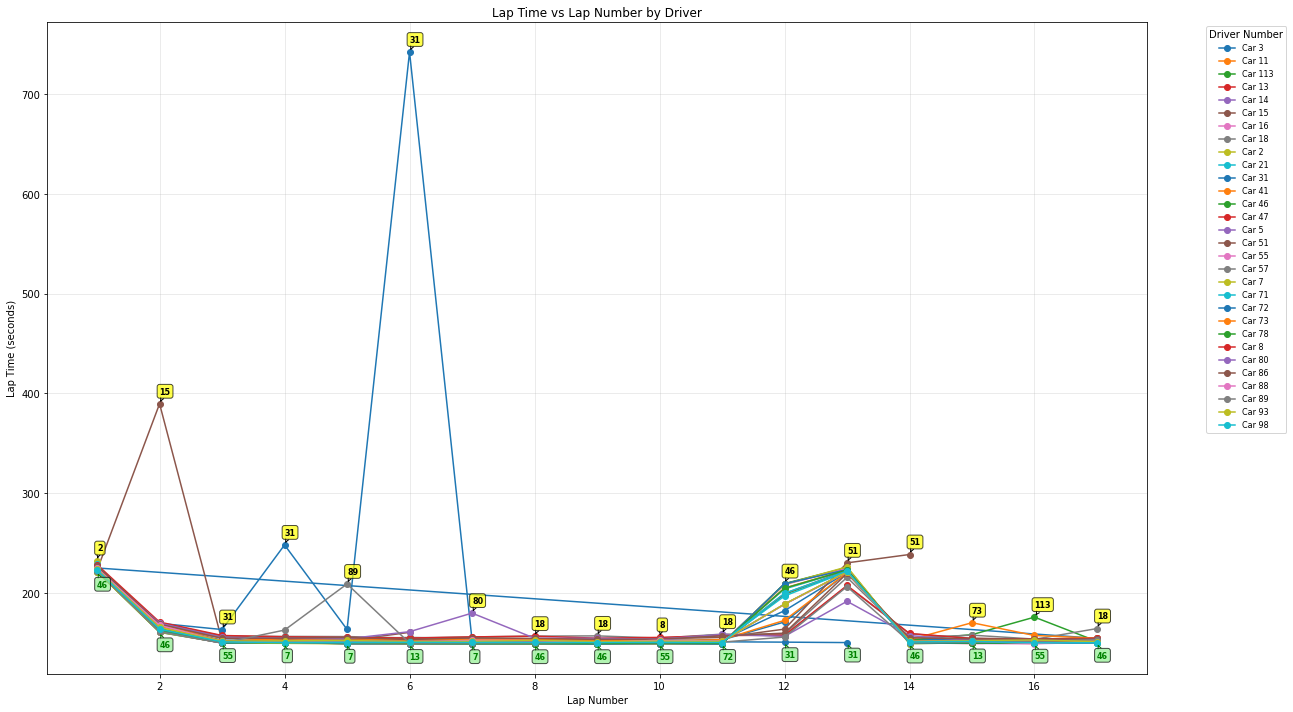

In [6]:
#check safety car lap 
plt.figure(figsize=(18, 10))

# Plot each driver's lap times with different colors
for driver in df_lap_origin['NUMBER'].unique():
    driver_data = df_lap_origin[df_lap_origin['NUMBER'] == driver]
    plt.plot(driver_data['LAP_NUMBER'], driver_data['lap_time_seconds'], marker='o', label=f'Car {int(driver)}')

# For each lap, find and label the slowest and fastest
for lap_num in df_lap_origin['LAP_NUMBER'].unique():
    lap_data = df_lap_origin[df_lap_origin['LAP_NUMBER'] == lap_num]
    
    # Slowest lap time for this lap
    slowest = lap_data.loc[lap_data['lap_time_seconds'].idxmax()]
    plt.annotate(f"{int(slowest['NUMBER'])}", 
                 xy=(slowest['LAP_NUMBER'], slowest['lap_time_seconds']),
                 xytext=(0, 10), textcoords='offset points',
                 fontsize=8, fontweight='bold', color='black',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
    # Fastest lap time for this lap
    fastest = lap_data.loc[lap_data['lap_time_seconds'].idxmin()]
    plt.annotate(f"{int(fastest['NUMBER'])}", 
                 xy=(fastest['LAP_NUMBER'], fastest['lap_time_seconds']),
                 xytext=(0, -15), textcoords='offset points',
                 fontsize=8, fontweight='bold', color='green',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', color='green', lw=1))

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Time vs Lap Number by Driver')
plt.legend(title='Driver Number', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
#Filter out in/out/safety car lap
df_lap_normal = df_lap_origin[~df_lap_origin['LAP_NUMBER'].isin([1, 13, 17])]

In [13]:
# Using isolation forest to find anomalie cars

print("Anomalies cars\n")

def trimmed_mean(x):
    return trim_mean(x, proportiontocut=0.1)

# ADD THIS SECTION: Create isolation_forest_flag
# Prepare features for Isolation Forest
features = df_lap_normal[['LAP_NUMBER', 'lap_time_seconds']].copy()

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expected proportion of outliers (5%)
    random_state=42,
    n_estimators=100
)

# Predict: -1 for outliers, 1 for inliers
predictions = iso_forest.fit_predict(features_scaled)

# Add Isolation Forest results to dataframe
df_lap_normal['isolation_forest_flag'] = (predictions == -1).astype(int)
# END OF ADDED SECTION

# Rest of your existing code (unchanged)
iso_summary = df_lap_normal.groupby('LAP_NUMBER').agg({
    'NUMBER': 'count',  # Total number of cars that completed this lap
    'lap_time_seconds': ['mean', 'std', 'min', 'max', trimmed_mean]
})

# Count unique cars flagged as anomalies per lap
anomaly_cars_per_lap = df_lap_normal[df_lap_normal['isolation_forest_flag'] == 1].groupby('LAP_NUMBER')['NUMBER'].nunique()

# Get the actual car numbers as a list for each lap
anomaly_car_numbers = df_lap_normal[df_lap_normal['isolation_forest_flag'] == 1].groupby('LAP_NUMBER')['NUMBER'].apply(lambda x: sorted(x.unique().tolist()))

iso_summary = df_lap_normal.groupby('LAP_NUMBER').agg({
    'NUMBER': 'count',  # Total number of cars that completed this lap
    'lap_time_seconds': ['mean', 'std', 'min', 'max', trimmed_mean]
})

# Count unique cars flagged as anomalies per lap
anomaly_cars_per_lap = df_lap_normal[df_lap_normal['isolation_forest_flag'] == 1].groupby('LAP_NUMBER')['NUMBER'].nunique()

# Get the actual car numbers as a list for each lap
anomaly_car_numbers = df_lap_normal[df_lap_normal['isolation_forest_flag'] == 1].groupby('LAP_NUMBER')['NUMBER'].apply(lambda x: sorted(x.unique().tolist()))

# Flatten column names
iso_summary.columns = ['Total_Cars', 'Mean_Time', 'Std_Dev', 'Min_Time', 'Max_Time', 'Trimmed_Mean']

# Add the anomaly car count and car numbers
iso_summary['Anomaly_Cars'] = anomaly_cars_per_lap
iso_summary['Anomaly_Cars'] = iso_summary['Anomaly_Cars'].fillna(0).astype(int)
iso_summary['Anomaly_%'] = (iso_summary['Anomaly_Cars'] / iso_summary['Total_Cars'] * 100).round(2)
iso_summary['Anomaly_Car_Numbers'] = anomaly_car_numbers
iso_summary['Anomaly_Car_Numbers'] = iso_summary['Anomaly_Car_Numbers'].fillna('').apply(lambda x: x if x != '' else '')

# Calculate baseline trimmed mean (median of all trimmed means to avoid safety car laps)
baseline_trimmed_mean = iso_summary['Trimmed_Mean'].median()
safety_car_threshold_low = baseline_trimmed_mean + 20  # 20 seconds slower
safety_car_threshold_high = baseline_trimmed_mean + 50  # 50 seconds slower

# Calculate std dev statistics to identify unusual laps
overall_mean_std = iso_summary['Std_Dev'].mean()
overall_std_of_std = iso_summary['Std_Dev'].std()

# Flag laps with unusually high std dev (potential incidents)
std_threshold = overall_mean_std + 1.5 * overall_std_of_std
iso_summary['High_StdDev_Flag'] = (iso_summary['Std_Dev'] > std_threshold).astype(int)

# Flag potential safety car laps
iso_summary['Safety_Car_Flag'] = ((iso_summary['Trimmed_Mean'] >= safety_car_threshold_low) & 
                                   (iso_summary['Trimmed_Mean'] <= safety_car_threshold_high)).astype(int)

# Add interpretation column with safety car detection
def interpret_lap(row):
    # Check for safety car first (most significant)
    if row['Safety_Car_Flag'] == 1:
        return 'Safety_Car'
    # Then check for incidents
    elif row['High_StdDev_Flag'] == 1 and row['Anomaly_Cars'] > 0:
        return 'INCIDENT_LIKELY'
    elif row['High_StdDev_Flag'] == 1:
        return 'High_Variance'
    elif row['Anomaly_Cars'] > 0:
        return 'Few_Outliers'
    else:
        return 'Clean_Racing'

iso_summary['Interpretation'] = iso_summary.apply(interpret_lap, axis=1)

iso_summary = iso_summary.round(3)

# Replace NaN with empty string for display
display(iso_summary.fillna(''))

# Show baseline information
print("\n" + "="*80)
print("Baseline Metrics:")
print("="*80)
print(f"Baseline Trimmed Mean Lap Time: {baseline_trimmed_mean:.3f}s")
print(f"Safety Car Detection Range: {safety_car_threshold_low:.3f}s - {safety_car_threshold_high:.3f}s")
print(f"Std Dev Threshold: {std_threshold:.3f}s")
print(f"Mean Std Dev: {overall_mean_std:.3f} ± {overall_std_of_std:.3f}s")

# Show detailed breakdown for non-clean laps
non_clean_laps = iso_summary[iso_summary['Interpretation'] != 'Clean_Racing']

# Safety Car laps summary
safety_car_laps = iso_summary[iso_summary['Interpretation'] == 'Safety_Car']
if len(safety_car_laps) > 0:
    print("\n" + "="*80)
    print(f"🚨 SAFETY CAR LAPS DETECTED ({len(safety_car_laps)} laps):")
    print("="*80)
    for lap_num in safety_car_laps.index:
        row = safety_car_laps.loc[lap_num]
        delta = row['Trimmed_Mean'] - baseline_trimmed_mean
        print(f"Lap {lap_num}: Trimmed Mean = {row['Trimmed_Mean']:.2f}s ({delta:+.2f}s vs baseline)")
else:
    print("\n✓ No safety car periods detected")

# Highlight suspicious laps (incidents)
print("\n" + "="*80)
print("⚠️  INCIDENT ANALYSIS")
print("="*80)

suspicious_laps = iso_summary[iso_summary['High_StdDev_Flag'] == 1]
if len(suspicious_laps) > 0:
    print(f"\nLaps with likely incidents (High Std Dev): {len(suspicious_laps)}")
    for lap_num in suspicious_laps.index:
        row = suspicious_laps.loc[lap_num]
        print(f"\nLap {lap_num}:")
        print(f"  - Std Dev: {row['Std_Dev']:.3f}s (threshold: {std_threshold:.3f}s)")
        print(f"  - {int(row['Anomaly_Cars'])} cars flagged as anomalies ({row['Anomaly_%']:.1f}%)")
        print(f"  - Lap time range: {row['Min_Time']:.2f}s - {row['Max_Time']:.2f}s")
        
        if row['Anomaly_Car_Numbers'] != '' and len(row['Anomaly_Car_Numbers']) > 0:
            print(f"  - Affected cars: {row['Anomaly_Car_Numbers']}")
else:
    print("\n✓ No laps with unusually high variance detected")

clean_laps = iso_summary[iso_summary['Interpretation'] == 'Clean_Racing']
print(f"\n✓ CLEAN RACING LAPS ({len(clean_laps)} laps):")
print(f"Laps: {sorted(clean_laps.index.tolist())}")
if len(clean_laps) > 0:
    print(f"Average Std Dev: {clean_laps['Std_Dev'].mean():.3f}s")

iso_summary = iso_summary.reset_index()

Anomalies cars



C:\Users\Leah\AppData\Local\Temp\ipykernel_12068\115278874.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lap_normal['isolation_forest_flag'] = (predictions == -1).astype(int)


,Total_Cars,Mean_Time,Std_Dev,Min_Time,Max_Time,Trimmed_Mean,Anomaly_Cars,Anomaly_%,Anomaly_Car_Numbers,High_StdDev_Flag,Safety_Car_Flag,Interpretation
LAP_NUMBER,,,,,,,,,,,,
2,30,172.419,41.132,160.534,389.514,165.008,2,6.67,"[8, 15]",0,0,Few_Outliers
3,30,152.535,3.222,149.734,163.327,152.052,0,0.00,,0,0,Clean_Racing
4,30,155.442,17.721,149.479,248.091,151.939,1,3.33,[31],0,0,Few_Outliers
5,30,154.046,10.798,149.056,208.982,151.896,1,3.33,[89],0,0,Few_Outliers
6,30,171.482,107.797,148.862,741.996,151.424,1,3.33,[31],1,0,INCIDENT_LIKELY
7,29,152.495,5.747,148.678,179.778,151.564,1,3.45,[80],0,0,Few_Outliers
8,29,151.525,2.393,148.630,156.707,151.336,0,0.00,,0,0,Clean_Racing
9,29,151.309,2.273,148.659,156.960,151.157,0,0.00,,0,0,Clean_Racing
10,29,151.308,2.055,148.679,155.429,151.212,0,0.00,,0,0,Clean_Racing



Baseline Metrics:
Baseline Trimmed Mean Lap Time: 151.811s
Safety Car Detection Range: 171.811s - 201.811s
Std Dev Threshold: 59.705s
Mean Std Dev: 17.399 ± 28.204s

🚨 SAFETY CAR LAPS DETECTED (1 laps):
Lap 12: Trimmed Mean = 186.53s (+34.72s vs baseline)

⚠️  INCIDENT ANALYSIS

Laps with likely incidents (High Std Dev): 1

Lap 6:
  - Std Dev: 107.797s (threshold: 59.705s)
  - 1 cars flagged as anomalies (3.3%)
  - Lap time range: 148.86s - 742.00s
  - Affected cars: [31]

✓ CLEAN RACING LAPS (5 laps):
Laps: [3, 8, 9, 10, 11]
Average Std Dev: 2.621s


Load telemetry data for corner performance analysis
1. load telemetry data
2. filter out in/out/safety cat laps

In [9]:
df_tele_origin = con.execute("""
    SELECT *
    FROM read_parquet('s3://toyota-gr-racing/parquet_cota_race1/R1_cota_telemetry_data.parquet')
""").df()

display(df_tele_origin.head() )

,expire_at,lap,meta_event,meta_session,meta_source,meta_time,original_vehicle_id,outing,telemetry_name,telemetry_value,timestamp,vehicle_id,vehicle_number
0,None,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-27 06:54:55.984000+10:00,GR86-002-2,0,accx_can,0.262,2025-04-25 06:53:32.719000+10:00,GR86-002-2,2
1,None,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-27 06:54:55.984000+10:00,GR86-002-2,0,accy_can,-0.093,2025-04-25 06:53:32.719000+10:00,GR86-002-2,2
2,None,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-27 06:54:55.984000+10:00,GR86-002-2,0,ath,100.010,2025-04-25 06:53:32.719000+10:00,GR86-002-2,2
3,None,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-27 06:54:55.984000+10:00,GR86-002-2,0,pbrake_r,0.000,2025-04-25 06:53:32.719000+10:00,GR86-002-2,2
4,None,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-27 06:54:55.984000+10:00,GR86-002-2,0,pbrake_f,0.000,2025-04-25 06:53:32.719000+10:00,GR86-002-2,2


Mark corners

Key columns:
  - vehicle_number: Vehicle identifier
  - lap: Lap number
  - corner_id: Corner identifier (0 = straight, 1-N = corner number)
  - in_corner: Boolean flag for corner vs straight
  - timestamp: Data timestamp
  - lap_progress: % through the lap (0-100)
  - speed, accy_can, abs_lat_g, accx_can, etc.: Telemetry values

In [14]:
#filter out in/out/safety car laps
df_tele_normal = df_tele_origin[~df_tele_origin['lap'].isin([1, 13, 17])]

#filter out anomaly cars
anomaly_vehicles = (
     iso_summary[['LAP_NUMBER', 'Anomaly_Car_Numbers']]
    .explode('Anomaly_Car_Numbers')
    .dropna(subset=['Anomaly_Car_Numbers'])
    .rename(columns={'LAP_NUMBER': 'lap', 'Anomaly_Car_Numbers': 'vehicle_number'})
)

#filter out anomaly vehicles from telemetry
df_tele_filtered = df_tele_normal.merge(
    anomaly_vehicles,
    on=['lap', 'vehicle_number'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop('_merge', axis=1)

In [15]:
#review telemetry data
df = df_tele_normal.groupby('telemetry_name').agg(
    min_value=('telemetry_value', 'min'),
    max_value=('telemetry_value', 'max'),
    avg_value=('telemetry_value', 'mean')
).reset_index().sort_values('telemetry_name')

display(df)

,telemetry_name,min_value,max_value,avg_value
0,Steering_Angle,-473.800,453.100,-3.710770
1,accx_can,-3.181,2.099,0.013204
2,accy_can,-3.595,2.533,0.038153
3,ath,0.000,100.430,52.370407
4,gear,-1.000,6.000,2.298178
5,nmot,0.000,7903.000,4918.887609
6,pbrake_f,0.000,163.770,4.369796
7,pbrake_r,0.000,165.295,4.445706
8,speed,0.000,213.660,99.182957


In [16]:
# Convert from LONG to WIDE format
df_tele_wide = df_tele_normal.pivot_table(
    index=['vehicle_number', 'lap', 'timestamp'],
    columns='telemetry_name',
    values='telemetry_value'
).reset_index()

print("✅ Converted to wide format!")

✅ Converted to wide format!


In [17]:
#fill NaN values in nmot and speed by using linear interpolation
df_tele_wide['nmot'] = df_tele_wide['nmot'].interpolate(method='linear')
df_tele_wide['speed'] = df_tele_wide['speed'].interpolate(method='linear')

# Handle any remaining NaNs at start/end
df_tele_wide['nmot'] = df_tele_wide['nmot'].bfill().ffill()
df_tele_wide['speed'] = df_tele_wide['speed'].bfill().ffill()
df_tele_wide2  = df_tele_wide[df_tele_wide['speed'] > 0]
df_tele_wide2 = df_tele_wide2.reset_index()
#sample data
#df_tele_wide[(df_tele_wide['lap']== 8) & (df_tele_wide['vehicle_number']==98)].sort_values('timestamp').head(50)
print("✅ Filled null data with linear interpolation.")

✅ Filled null data with linear interpolation.


STEP 1: DETECTING CONSENSUS CORNERS

Processing 454 vehicle-laps to find consensus corners...
  Progress: 0.2%
  Progress: 22.0%
  Progress: 44.1%
  Progress: 66.1%
  Progress: 88.1%

Creating consensus corners...
  Bins marked as corners: 106
  Initial corners: 12

Filtering corners (span >1.5% AND ≥30% vehicles)...
  ✅ Consensus corners after filtering: 9

Consensus corner ranges:
  Corner 1.0: 4.0%-7.5% (span 3.5%, 30.0 vehicles)
  Corner 2.0: 9.0%-12.5% (span 3.5%, 30.0 vehicles)
  Corner 3.0: 19.0%-31.0% (span 12.0%, 30.0 vehicles)
  Corner 4.0: 38.5%-42.0% (span 3.5%, 30.0 vehicles)
  Corner 5.0: 57.5%-61.5% (span 4.0%, 30.0 vehicles)
  Corner 6.0: 62.5%-73.5% (span 11.0%, 30.0 vehicles)
  Corner 7.0: 75.5%-83.0% (span 7.5%, 30.0 vehicles)
  Corner 8.0: 84.5%-87.0% (span 2.5%, 30.0 vehicles)
  Corner 9.0: 90.0%-93.5% (span 3.5%, 30.0 vehicles)

✅ Processing complete: 454 vehicle-lap combinations

Total corners detected: 2,656
Vehicles with corners: 29
Average corners per lap: 6.1

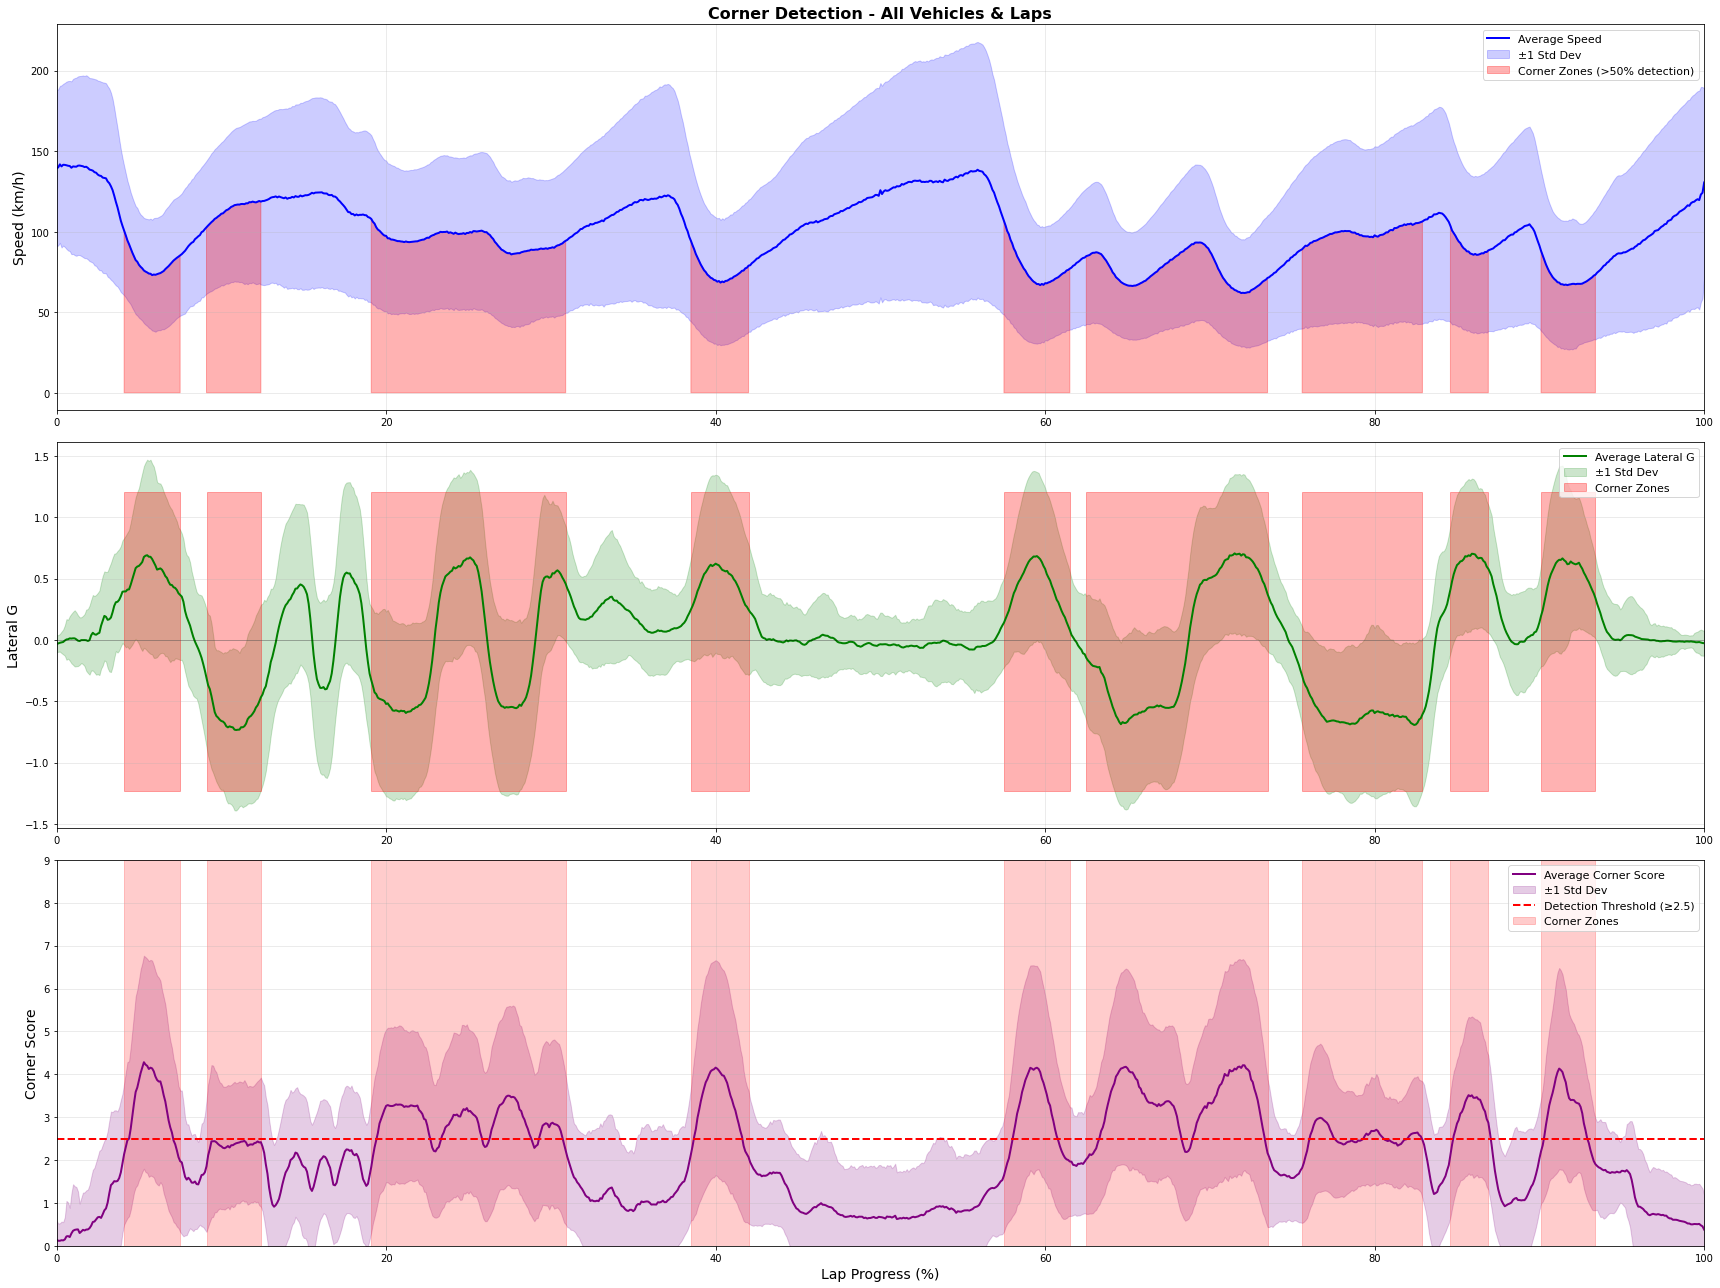

In [19]:
#mark corners - Lateral G with bins
def identify_corners_improved(telemetry, consensus_corners=None):
    """
    Corner detection - can work with pre-defined consensus corners
    
    If consensus_corners is provided, uses those instead of detecting independently
    """
    # Check if we have enough data
    if len(telemetry) < 10:
        return pd.DataFrame(), telemetry
    
    telemetry['lap_progress'] = np.linspace(0, 100, len(telemetry))
    
    # Calculate signals
    telemetry['abs_lat_g'] = abs(telemetry['accy_can'])
    
    lat_g_signal = telemetry['abs_lat_g'] > 0.8  
    steering_signal = abs(telemetry['Steering_Angle']) > 80
    
    max_speed = telemetry['speed'].quantile(0.95)
    speed_signal = telemetry['speed'] < (max_speed * 0.70)
    
    brake_signal = (telemetry['pbrake_f'] > 20) | (telemetry['pbrake_r'] > 20)
    decel_signal = telemetry['accx_can'] < -0.5
    
    # Calculate corner score
    telemetry['corner_score'] = (
        lat_g_signal.astype(int) * 3 +
        steering_signal.astype(int) * 2 +
        speed_signal.astype(int) * 1.5 +
        brake_signal.astype(int) * 0.5 +
        decel_signal.astype(int) * 0.5
    )
    
    # Bin lap_progress
    telemetry['lap_progress_bin'] = (telemetry['lap_progress'] / 0.5).astype(int)
    
    # If consensus corners provided, use them; otherwise detect independently
    if consensus_corners is not None:
        # Assign consensus corners
        telemetry['corner_id'] = 0
        telemetry['is_corner'] = False
        
        for _, corner in consensus_corners.iterrows():
            mask = (telemetry['lap_progress'] >= corner['start']) & (telemetry['lap_progress'] < corner['end'])
            telemetry.loc[mask, 'corner_id'] = corner['corner_id']
            telemetry.loc[mask, 'is_corner'] = True
    else:
        # Original independent detection (for initial pass)
        bin_stats = telemetry.groupby('lap_progress_bin').agg({
            'corner_score': 'mean',
            'speed': 'mean'
        }).reset_index()
        
        corner_score_threshold = 2
        bin_stats['is_corner'] = bin_stats['corner_score'] >= corner_score_threshold
        
        high_speed_threshold = telemetry['speed'].quantile(0.85)
        bin_stats.loc[bin_stats['speed'] > high_speed_threshold, 'is_corner'] = False
        
        bin_stats = bin_stats.sort_values('lap_progress_bin').reset_index(drop=True)
        bin_stats['corner_id'] = 0
        corner_id = 0
        
        for idx in range(len(bin_stats)):
            if bin_stats.loc[idx, 'is_corner']:
                if idx == 0 or not bin_stats.loc[idx-1, 'is_corner']:
                    corner_id += 1
                bin_stats.loc[idx, 'corner_id'] = corner_id
        
        telemetry = telemetry.merge(
            bin_stats[['lap_progress_bin', 'is_corner', 'corner_id']], 
            on='lap_progress_bin', 
            how='left',
            suffixes=('_old', '')
        )
        
        if 'is_corner_old' in telemetry.columns:
            telemetry.drop('is_corner_old', axis=1, inplace=True)
        if 'corner_id_old' in telemetry.columns:
            telemetry.drop('corner_id_old', axis=1, inplace=True)
        
        telemetry['is_corner'] = telemetry['is_corner'].fillna(False)
        telemetry['corner_id'] = telemetry['corner_id'].fillna(0).astype(int)
    
    # Create corner summary
    corner_data = telemetry[telemetry['is_corner']]
    
    if len(corner_data) == 0:
        return pd.DataFrame(), telemetry
    
    corners = corner_data.groupby('corner_id').agg({
        'timestamp': ['min', 'max', 'count'],
        'abs_lat_g': ['mean', 'max'],
        'speed': ['min', 'mean', 'max'],
        'Steering_Angle': ['mean', 'max', 'std'],
        'accx_can': ['min', 'mean'],
        'accy_can': lambda x: 'left' if x.mean() > 0 else 'right',
        'pbrake_f': 'max',
        'gear': 'min',
        'lap_progress': ['min', 'max']
    }).reset_index()
    
    corners['lap_progress_span'] = corners[('lap_progress', 'max')] - corners[('lap_progress', 'min')]
    corners = corners[corners['lap_progress_span'] > 2.0]
    corners = corners[corners[('timestamp', 'count')] > 10]
    
    if len(corners) > 0:
        median_speed = telemetry['speed'].median()
        corners = corners[corners[('speed', 'mean')] < median_speed]
    
    if len(corners) > 0:
        corners = classify_corners_detailed(corners)
    
    return corners, telemetry

def classify_corners_detailed(corners):
    """
    Classify corner type based on multiple characteristics
    """
    corners['corner_number'] = range(1, len(corners) + 1)
    # Speed classification - adjusted thresholds
    corners['speed_type'] = corners[('speed', 'mean')].apply(
        lambda x: 'slow' if x < 60 else ('medium' if x < 100 else 'fast')
    )
    
    # Load classification (lateral G)
    corners['load_type'] = corners[('abs_lat_g', 'max')].apply(
        lambda x: 'low' if x < 0.9 else ('medium' if x < 1.3 else 'high')
    )
    
    # Turn direction
    corners['direction'] = corners[('accy_can', '<lambda>')]
    
    # Severity (combination of factors)
    corners['severity_score'] = (
        corners[('abs_lat_g', 'max')] +  # High G = harder corner
        (150 - corners[('speed', 'mean')]) / 50 +  # Lower speed = harder
        abs(corners[('Steering_Angle', 'max')]) / 100  # More steering = sharper
    )
    
    return corners

# ==============================================================================
# STEP 1: FIRST PASS - DETECT CONSENSUS CORNERS
# ==============================================================================
print("STEP 1: DETECTING CONSENSUS CORNERS")
all_bin_data = []
vehicle_lap_combos = df_tele_wide.groupby(['vehicle_number', 'lap'])
total_combos = len(vehicle_lap_combos)
total_vehicles = df_tele_wide['vehicle_number'].nunique()

print(f"\nProcessing {total_combos} vehicle-laps to find consensus corners...")

for i, ((vehicle, lap), group_data) in enumerate(vehicle_lap_combos, 1):
    if i % 100 == 0 or i == 1:
        print(f"  Progress: {100*i/total_combos:.1f}%")
    
    try:
        group_data = group_data.sort_values('timestamp').reset_index(drop=True)
        _, telemetry = identify_corners_improved(group_data.copy(), consensus_corners=None)
        all_bin_data.append(telemetry[['lap_progress_bin', 'corner_score', 'speed', 'vehicle_number']])
    except:
        continue

# Create consensus corners from all vehicles
print("\nCreating consensus corners...")
all_bins = pd.concat(all_bin_data, ignore_index=True)

bin_consensus = all_bins.groupby('lap_progress_bin').agg({
    'corner_score': 'mean',
    'speed': 'mean',
    'vehicle_number': 'nunique'
}).reset_index()

corner_score_threshold = 2
high_speed_threshold = all_bins['speed'].quantile(0.85)

bin_consensus['is_corner'] = (
    (bin_consensus['corner_score'] >= corner_score_threshold) &
    (bin_consensus['speed'] < high_speed_threshold)
)

print(f"  Bins marked as corners: {bin_consensus['is_corner'].sum()}")

# Assign corner IDs to consecutive bins
bin_consensus = bin_consensus.sort_values('lap_progress_bin').reset_index(drop=True)
bin_consensus['corner_id'] = 0
corner_id = 0

for idx in range(len(bin_consensus)):
    if bin_consensus.loc[idx, 'is_corner']:
        if idx == 0 or not bin_consensus.loc[idx-1, 'is_corner']:
            corner_id += 1
        bin_consensus.loc[idx, 'corner_id'] = corner_id

print(f"  Initial corners: {corner_id}")

# Filter corners by span and vehicle count
print("\nFiltering corners (span >1.5% AND ≥30% vehicles)...")

consensus_corners = []
for cid in range(1, corner_id + 1):
    corner_bins = bin_consensus[bin_consensus['corner_id'] == cid]
    start = corner_bins['lap_progress_bin'].min() * 0.5
    end = (corner_bins['lap_progress_bin'].max() + 1) * 0.5
    span = end - start
    
    # Count vehicles in this corner
    corner_mask = all_bins['lap_progress_bin'].isin(corner_bins['lap_progress_bin'])
    num_vehicles = all_bins[corner_mask]['vehicle_number'].nunique()
    
    if span >= 2 and num_vehicles >= (total_vehicles * 0.3):
        consensus_corners.append({
            'corner_id': len(consensus_corners) + 1,
            'start': start,
            'end': end,
            'span': span,
            'num_vehicles': num_vehicles
        })

consensus_corners_df = pd.DataFrame(consensus_corners)
print(f"  ✅ Consensus corners after filtering: {len(consensus_corners_df)}")

if len(consensus_corners_df) > 0:
    print("\nConsensus corner ranges:")
    for _, cr in consensus_corners_df.iterrows():
        print(f"  Corner {cr['corner_id']}: {cr['start']:.1f}%-{cr['end']:.1f}% (span {cr['span']:.1f}%, {cr['num_vehicles']} vehicles)")

# ==============================================================================
# STEP 2: SECOND PASS - APPLY CONSENSUS CORNERS TO ALL VEHICLE-LAPS
# ==============================================================================
all_corners_improved = []
all_telemetry_improved = []

processed = 0
errors = 0

for i, ((vehicle, lap), group_data) in enumerate(vehicle_lap_combos, 1):    
    try:
        group_data = group_data.sort_values('timestamp').reset_index(drop=True)
        corners_df, telemetry_with_corners = identify_corners_improved(
            group_data.copy(), 
            consensus_corners=consensus_corners_df
        )
        
        if len(corners_df) > 0:
            corners_df['vehicle_number'] = vehicle
            corners_df['lap'] = lap
            all_corners_improved.append(corners_df)
        
        telemetry_with_corners['vehicle_number'] = vehicle
        telemetry_with_corners['lap'] = lap
        all_telemetry_improved.append(telemetry_with_corners)
        processed += 1
    except Exception as e:
        errors += 1
        continue

print(f"\n✅ Processing complete: {processed} vehicle-lap combinations")
if errors > 0:
    print(f"⚠️ {errors} combinations had errors")

# ==============================================================================
# COMBINE RESULTS AND STATISTICS
# ==============================================================================

if len(all_corners_improved) > 0:
    final_corners_improved = pd.concat(all_corners_improved, ignore_index=True)
    
    print(f"\nTotal corners detected: {len(final_corners_improved):,}")
    print(f"Vehicles with corners: {final_corners_improved['vehicle_number'].nunique()}")
    print(f"Average corners per lap: {final_corners_improved.groupby(['vehicle_number', 'lap']).size().mean():.1f}")

if len(all_telemetry_improved) > 0:
    all_telemetry = pd.concat(all_telemetry_improved, ignore_index=True)
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("CORNER STATISTICS")
    print(f"{'='*80}")
    
    total_corners = all_telemetry[all_telemetry['is_corner']].shape[0]
    total_points = len(all_telemetry)
    corner_percentage = 100 * total_corners / total_points
    
    print(f"\nOverall statistics:")
    print(f"  Total data points: {total_points:,}")
    print(f"  Points in corners: {total_corners:,} ({corner_percentage:.1f}%)")
    print(f"  Average corner score: {all_telemetry['corner_score'].mean():.2f}")
    print(f"  Max corner score: {all_telemetry['corner_score'].max():.2f}")
    
    print(f"\nSpeed statistics:")
    print(f"  Average speed: {all_telemetry['speed'].mean():.1f} km/h")
    print(f"  Speed in corners: {all_telemetry[all_telemetry['is_corner']]['speed'].mean():.1f} km/h")
    print(f"  Speed in straights: {all_telemetry[~all_telemetry['is_corner']]['speed'].mean():.1f} km/h")
    print(f"  Speed difference: {all_telemetry[~all_telemetry['is_corner']]['speed'].mean() - all_telemetry[all_telemetry['is_corner']]['speed'].mean():.1f} km/h faster in straights")
    
    print(f"\nLateral G statistics:")
    print(f"  Average |lateral G|: {all_telemetry['abs_lat_g'].mean():.3f} g")
    print(f"  Max |lateral G|: {all_telemetry['abs_lat_g'].max():.3f} g")
    print(f"  Average in corners: {all_telemetry[all_telemetry['is_corner']]['abs_lat_g'].mean():.3f} g")
    print(f"  Average in straights: {all_telemetry[~all_telemetry['is_corner']]['abs_lat_g'].mean():.3f} g")
    
    # Corner-by-corner statistics
    print(f"\n{'='*80}")
    print("CORNER-BY-CORNER STATISTICS")
    print(f"{'='*80}")
    
    corner_stats = all_telemetry[all_telemetry['corner_id'] > 0].groupby('corner_id').agg({
        'speed': ['min', 'max', 'mean'],
        'vehicle_number': 'nunique',
        'lap_progress': ['min', 'max']
    }).reset_index()
    
    corner_stats.columns = ['Corner_ID', 'Min_Speed', 'Max_Speed', 'Mean_Speed', 'Num_Vehicles', 'Lap_Start_%', 'Lap_End_%']
    
    # Add corner type column
    corner_stats['Type'] = corner_stats['Mean_Speed'].apply(
        lambda x: 'Slow' if x < 80 else ('Medium' if x < 120 else 'Fast')
    )
    
    # Round numeric columns
    corner_stats['Min_Speed'] = corner_stats['Min_Speed'].round(1)
    corner_stats['Max_Speed'] = corner_stats['Max_Speed'].round(1)
    corner_stats['Mean_Speed'] = corner_stats['Mean_Speed'].round(1)
    corner_stats['Lap_Start_%'] = corner_stats['Lap_Start_%'].round(1)
    corner_stats['Lap_End_%'] = corner_stats['Lap_End_%'].round(1)
    
    print(f"\nTotal unique corners: {len(corner_stats)}")
    print(f"\n{corner_stats.to_string(index=False)}")
    
    # QAQC: Verify non-overlapping corners
    print(f"\n{'='*80}")
    print("QAQC: Verifying non-overlapping corners")
    print(f"{'='*80}")
    
    overlap_found = False
    for i in range(len(corner_stats) - 1):
        current_end = corner_stats.iloc[i]['Lap_End_%']
        next_start = corner_stats.iloc[i+1]['Lap_Start_%']
        if current_end >= next_start:
            print(f"⚠️ FAIL: Corner {corner_stats.iloc[i]['Corner_ID']} overlaps Corner {corner_stats.iloc[i+1]['Corner_ID']}")
            overlap_found = True
    
    if not overlap_found:
        print(f"✅ PASS: All corners are non-overlapping")
    
    # QAQC: Verify vehicle participation
    print(f"\nQAQC: Verifying vehicle participation (≥50% = {total_vehicles * 0.5:.0f} vehicles)")
    min_vehicles = corner_stats['Num_Vehicles'].min()
    if min_vehicles >= (total_vehicles * 0.5):
        print(f"✅ PASS: All corners have ≥50% vehicle participation (min: {min_vehicles})")
    else:
        print(f"⚠️ FAIL: Some corners have <50% vehicle participation (min: {min_vehicles})")
    
    print(f"\n{'='*80}")
    print(f"✅ COMPLETE! {total_vehicles} vehicles share {len(corner_stats)} non-overlapping corners")
    print(f"{'='*80}")
    
    # ==============================================================================
    # VISUALIZATION
    # ==============================================================================    
    fig, axes = plt.subplots(3, 1, figsize=(24, 18))
    
    # Plot 1: Speed profile
    ax1 = axes[0]
    speed_stats = all_telemetry.groupby(all_telemetry['lap_progress'].round(1)).agg({
        'speed': ['mean', 'std'],
        'is_corner': 'mean'
    })
    
    x = speed_stats.index
    speed_mean = speed_stats[('speed', 'mean')]
    speed_std = speed_stats[('speed', 'std')]
    corner_prop = speed_stats[('is_corner', 'mean')]
    
    ax1.plot(x, speed_mean, label='Average Speed', linewidth=2, color='blue')
    ax1.fill_between(x, speed_mean - speed_std, speed_mean + speed_std, 
                      alpha=0.2, color='blue', label='±1 Std Dev')
    ax1.fill_between(x, 0, speed_mean, 
                      where=corner_prop > 0.5,
                      alpha=0.3, color='red', label='Corner Zones (>50% detection)')
    
    ax1.set_ylabel('Speed (km/h)', fontsize=14)
    ax1.set_title(f'Corner Detection - All Vehicles & Laps', 
                  fontsize=16, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 100)
    
    # Plot 2: Lateral G
    ax2 = axes[1]
    lat_g_stats = all_telemetry.groupby(all_telemetry['lap_progress'].round(1)).agg({
        'accy_can': ['mean', 'std'],
        'is_corner': 'mean'
    })
    
    lat_g_mean = lat_g_stats[('accy_can', 'mean')]
    lat_g_std = lat_g_stats[('accy_can', 'std')]
    corner_prop = lat_g_stats[('is_corner', 'mean')]
    
    ax2.plot(x, lat_g_mean, label='Average Lateral G', linewidth=2, color='green')
    ax2.fill_between(x, lat_g_mean - lat_g_std, lat_g_mean + lat_g_std,
                      alpha=0.2, color='green', label='±1 Std Dev')
    ax2.fill_between(x, lat_g_mean.min() - 0.5, lat_g_mean.max() + 0.5,
                      where=corner_prop > 0.5,
                      alpha=0.3, color='red', label='Corner Zones')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2.set_ylabel('Lateral G', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 100)
    
    # Plot 3: Corner score
    ax3 = axes[2]
    score_stats = all_telemetry.groupby(all_telemetry['lap_progress'].round(1)).agg({
        'corner_score': ['mean', 'std'],
        'is_corner': 'mean'
    })
    
    score_mean = score_stats[('corner_score', 'mean')]
    score_std = score_stats[('corner_score', 'std')]
    corner_prop = score_stats[('is_corner', 'mean')]
    
    ax3.plot(x, score_mean, label='Average Corner Score', linewidth=2, color='purple')
    ax3.fill_between(x, score_mean - score_std, score_mean + score_std,
                      alpha=0.2, color='purple', label='±1 Std Dev')
    ax3.axhline(y=2.5, color='r', linestyle='--', linewidth=2, label='Detection Threshold (≥2.5)')
    ax3.fill_between(x, 0, 9,
                      where=corner_prop > 0.5,
                      alpha=0.2, color='red', label='Corner Zones')
    
    ax3.set_xlabel('Lap Progress (%)', fontsize=14)
    ax3.set_ylabel('Corner Score', fontsize=14)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 100)
    ax3.set_ylim(0, 9)
    
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ No corners detected with improved thresholds.")

In [20]:
# Corner Benchmarking Analysis - Standalone Functions
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =====================================================================
# EXTRACT CORNER PERFORMANCE (NO BEST LAP FILTER)
# =====================================================================
def extract_corner_performance(df_telemetry):
    """Extract corner performance metrics per lap, per car."""
    print("\n" + "="*80)
    print("EXTRACTING CORNER PERFORMANCE (per-lap, all laps)")
    print("="*80)

    df_analysis = df_telemetry.copy()
    
    # Use 'is_corner' instead of 'is_corner_zone'
    df_corners = df_analysis[df_analysis['is_corner'] == True].copy()
    if len(df_corners) == 0:
        print("⚠️ No corner zones found!")
        return pd.DataFrame()

    print(f"\n🔍 Analyzing {df_corners['corner_id'].nunique()} unique corners...")

    corner_metrics = []

    # Group by car, corner, lap
    for (car, corner_id, lap), group in df_corners.groupby(['vehicle_number', 'corner_id', 'lap']):
        if len(group) < 5:
            continue

        group_sorted = group.sort_values('lap_progress')
        n_points = len(group_sorted)
        third = n_points // 3

        entry_zone = group_sorted.iloc[:third]
        apex_zone = group_sorted.iloc[third:2 * third]
        exit_zone = group_sorted.iloc[2 * third:]

        corner_metrics.append({
            'vehicle_number': car,
            'lap': lap,
            'corner_id': int(corner_id),
            'corner_name': f'Turn {int(corner_id)}',
            'min_speed': group_sorted['speed'].min(),
            'avg_speed': group_sorted['speed'].mean(),
            'max_lat_g': group_sorted['abs_lat_g'].max(),
            'avg_lat_g': group_sorted['abs_lat_g'].mean(),
            'avg_pbrake_f': group_sorted['pbrake_f'].mean(),
            'avg_pbrake_r': group_sorted['pbrake_r'].mean(),
            'avg_Steering_Angle': group_sorted['Steering_Angle'].abs().mean(),
            'time_in_corner': len(group_sorted) * 0.01,  # seconds for this lap
            'entry_speed': entry_zone['speed'].mean(),
            'entry_min_speed': entry_zone['speed'].min(),
            'entry_braking': entry_zone['accx_can'].min(),
            'apex_speed': apex_zone['speed'].min(),
            'apex_lat_g': apex_zone['abs_lat_g'].max(),
            'apex_steering': apex_zone['Steering_Angle'].abs().max(),
            'exit_speed': exit_zone['speed'].mean(),
            'exit_max_speed': exit_zone['speed'].max(),
            'exit_acceleration': exit_zone['accx_can'].max(),
            'speed_variance': group_sorted['speed'].std(),
            'steering_variance': group_sorted['Steering_Angle'].std(),
            'avg_pbrake_f': group_sorted['pbrake_f'].mean(),      # add brake front
            'avg_pbrake_r': group_sorted['pbrake_r'].mean(),      # add brake rear
            'avg_steering': group_sorted['Steering_Angle'].mean(),# add avg steering
        })

    df_metrics = pd.DataFrame(corner_metrics)
    print(f"✅ Extracted metrics for {len(df_metrics)} corner passages")
    return df_metrics
def benchmark_against_fastest(df_metrics):
    """Compare each car to the fastest in each corner (shortest time)."""
    print("\n" + "="*80)
    print("BENCHMARKING AGAINST SHORTEST TIME PER CORNER")
    print("="*80)

    results = []

    for corner_id in df_metrics['corner_id'].unique():
        corner_data = df_metrics[df_metrics['corner_id'] == corner_id].copy()
        # Pick benchmark by shortest time_in_corner with speed > 0
        valid_data = corner_data[corner_data['avg_speed'] > 0]
        benchmark_idx = valid_data['time_in_corner'].idxmin()
        benchmark_car = valid_data.loc[benchmark_idx, 'vehicle_number']
        benchmark_metrics = valid_data.loc[benchmark_idx]

        # Compute average brake, lat_g, steering for benchmark (for printing)
        avg_pbrake_f = benchmark_metrics['avg_pbrake_f']
        avg_pbrake_r = benchmark_metrics['avg_pbrake_r']
        avg_steering = benchmark_metrics['avg_Steering_Angle']
        avg_lat_g = benchmark_metrics['avg_lat_g']

        print(f"Turn {int(corner_id)}: Benchmark is Car {int(benchmark_car)} "
              f"(time {benchmark_metrics['time_in_corner']:.3f}s) | "
              f"avg_pbrake_f {avg_pbrake_f:.2f} | avg_pbrake_r {avg_pbrake_r:.2f} | "
              f"avg_steering {avg_steering:.2f} | avg_lat_g {avg_lat_g:.2f}")

        # Compare each car to benchmark
        for idx, row in corner_data.iterrows():
            time_gap = row['time_in_corner'] - benchmark_metrics['time_in_corner']
            apex_speed_gap = row['apex_speed'] - benchmark_metrics['apex_speed']
            entry_speed_gap = row['entry_speed'] - benchmark_metrics['entry_speed']
            exit_speed_gap = row['exit_speed'] - benchmark_metrics['exit_speed']

            gaps = {
                'vehicle_number': row['vehicle_number'],
                'corner_id': row['corner_id'],
                'corner_name': row['corner_name'],
                'is_benchmark': row['vehicle_number'] == benchmark_car,
                'time_gap': time_gap,
                'apex_speed_gap': apex_speed_gap,
                'entry_speed_gap': entry_speed_gap,
                'exit_speed_gap': exit_speed_gap,
                'lat_g_gap': row['max_lat_g'] - benchmark_metrics['max_lat_g'],
                'avg_pbrake_f': row['avg_pbrake_f'],
                'avg_pbrake_r': row['avg_pbrake_r'],
                'avg_steering': row['avg_steering'],
                'avg_lat_g': row['avg_lat_g'],
            }
            results.append(gaps)

    df_gaps = pd.DataFrame(results)
    print(f"\n✅ Benchmarking complete for {df_gaps['corner_id'].nunique()} corners")
    return df_gaps

# =====================================================================
# REPORT & PLOTTING FUNCTIONS 
# =====================================================================

def generate_driver_report(df_gaps, vehicle_number):
    """Generate detailed report for a specific driver (per corner averages)."""
    driver_data = df_gaps[df_gaps['vehicle_number'] == vehicle_number].copy()
    
    if len(driver_data) == 0:
        return f"⚠️ No data found for car {vehicle_number}"

    # Average time lost per corner (per lap)
    avg_time_lost = driver_data['time_gap'].mean()
    avg_apex_gap = driver_data['apex_speed_gap'].mean()
    worst_corners = driver_data.nsmallest(5, 'time_gap')
    best_corners = driver_data.nlargest(3, 'time_gap')

    report = f"""
╔═══════════════════════════════════════════════════════════════╗
║          CORNER BENCHMARKING REPORT - CAR #{int(vehicle_number)}              ║
╚═══════════════════════════════════════════════════════════════╝

📊 OVERALL PERFORMANCE:
   Average time lost per corner (per lap): {avg_time_lost:.3f}s
   Average apex speed deficit: {avg_apex_gap:.2f} km/h
   Corners analyzed: {len(driver_data)}

🔴 TOP 5 PROBLEM CORNERS (avg time lost):
"""
    for idx, row in worst_corners.iterrows():
        report += f"\n   {row['corner_name']}: {row['time_gap']:.3f}s | " \
                  f"apex_gap {row['apex_speed_gap']:.1f} kph | " \
                  f"entry_gap {row['entry_speed_gap']:.1f} | " \
                  f"exit_gap {row['exit_speed_gap']:.1f}"

    report += f"\n\n✅ TOP 3 STRENGTHS (least time lost):"
    for idx, row in best_corners.iterrows():
        report += f"\n   {row['corner_name']}: {row['time_gap']:.3f}s"

    report += "\n" + "="*65
    return report

def visualize_corner_comparison(df_gaps, vehicle_number, save_path=None):
    """Create 4-panel visualization aggregated by corner_id"""
    driver_data = df_gaps[df_gaps['vehicle_number'] == vehicle_number].copy()

    if len(driver_data) == 0:
        print(f"⚠️ No data for car {vehicle_number}")
        return

    # ------------------------------------------------------------------
    # Aggregate by corner_id for x-axis
    # ------------------------------------------------------------------
    agg_data = driver_data.groupby('corner_id').agg({
        'apex_speed_gap': 'mean',
        'lat_g_gap': 'mean',
        'time_gap': 'mean',
        'avg_pbrake_f': 'mean',
        'avg_pbrake_r': 'mean',
        'avg_steering': 'mean',
        'avg_lat_g': 'mean'
    }).reset_index()

    x = agg_data['corner_id']

    # ------------------------------------------------------------------
    # Prepare figure
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Corner Performance - Car #{int(vehicle_number)}', fontsize=16, fontweight='bold')

    # Apex speed gap vs corner
    axes[0, 0].bar(x, agg_data['apex_speed_gap'], color=['red' if v < 0 else 'green' for v in agg_data['apex_speed_gap']])
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 0].set_xlabel('Corner ID')
    axes[0, 0].set_ylabel('Apex Speed Gap (kph)')
    axes[0, 0].set_title('Apex Speed vs Benchmark')
    axes[0, 0].grid(True, alpha=0.3)

    # Lateral G gap vs corner
    axes[0, 1].bar(x, agg_data['lat_g_gap'], color=['red' if v < 0 else 'green' for v in agg_data['lat_g_gap']])
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].set_xlabel('Corner ID')
    axes[0, 1].set_ylabel('Lat G Gap (g)')
    axes[0, 1].set_title('Grip Usage vs Benchmark')
    axes[0, 1].grid(True, alpha=0.3)

    # ------------------------------------------------------------------
    # Phase / brake / steering summary pie chart (optional)
    # ------------------------------------------------------------------
    # Here we use avg values as placeholder for pie chart: e.g., top 3 average brakes
    pie_labels = ['Front Brake', 'Rear Brake', 'Steering', 'Lat G']
    pie_values = [
        agg_data['avg_pbrake_f'].mean(),
        agg_data['avg_pbrake_r'].mean(),
        agg_data['avg_steering'].mean(),
        agg_data['avg_lat_g'].mean()
    ]
    axes[1, 0].pie(pie_values, labels=pie_labels, autopct='%1.1f%%', colors=['#ff6b6b', '#ffd93d', '#6bcf7f', '#4dabf7'])
    axes[1, 0].set_title('Average Control/Grip Usage')

    # Time gap per corner
    axes[1, 1].bar(x, agg_data['time_gap'], color=['red' if v > 0 else 'green' for v in agg_data['time_gap']])
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 1].set_xlabel('Corner ID')
    axes[1, 1].set_ylabel('Time Lost (s)')
    axes[1, 1].set_title('Average Time Lost Per Corner')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✅ Saved to {save_path}")
    plt.show()

def compare_all_drivers(df_gaps):
    """Compare all drivers overall"""
    summary = df_gaps.groupby('vehicle_number').agg({
        'time_gap': 'sum',
        'apex_speed_gap': 'mean',
        'lat_g_gap': 'mean'
    }).sort_values('time_gap')
    summary.columns = ['Total Time Lost (s)', 'Avg Apex Gap (kph)', 'Avg Lat G Gap (g)']
    
    print("\n🏆 OVERALL RANKING:")
    for rank, (car, row) in enumerate(summary.iterrows(), 1):
        print(f"  #{rank}. Car {int(car):3d}: {row['Total Time Lost (s)']:+.3f}s")
    
    return summary

print("✅ Corner benchmarking functions loaded!")

✅ Corner benchmarking functions loaded!



EXTRACTING CORNER PERFORMANCE (per-lap, all laps)

🔍 Analyzing 9 unique corners...
✅ Extracted metrics for 4086 corner passages

BENCHMARKING AGAINST SHORTEST TIME PER CORNER
Turn 1: Benchmark is Car 113 (time 0.190s) | avg_pbrake_f 0.00 | avg_pbrake_r 0.00 | avg_steering 32.43 | avg_lat_g 0.02
Turn 2: Benchmark is Car 113 (time 0.190s) | avg_pbrake_f 0.44 | avg_pbrake_r 0.32 | avg_steering 121.77 | avg_lat_g 0.08
Turn 3: Benchmark is Car 113 (time 0.660s) | avg_pbrake_f 0.00 | avg_pbrake_r 0.00 | avg_steering 97.87 | avg_lat_g 0.06
Turn 4: Benchmark is Car 113 (time 0.190s) | avg_pbrake_f 3.22 | avg_pbrake_r 2.72 | avg_steering 3.44 | avg_lat_g 0.02
Turn 5: Benchmark is Car 113 (time 0.220s) | avg_pbrake_f 1.61 | avg_pbrake_r 1.54 | avg_steering 190.53 | avg_lat_g 0.01
Turn 6: Benchmark is Car 113 (time 0.600s) | avg_pbrake_f 0.06 | avg_pbrake_r 0.00 | avg_steering 192.23 | avg_lat_g 0.02
Turn 7: Benchmark is Car 113 (time 0.410s) | avg_pbrake_f 6.51 | avg_pbrake_r 6.38 | avg_steerin

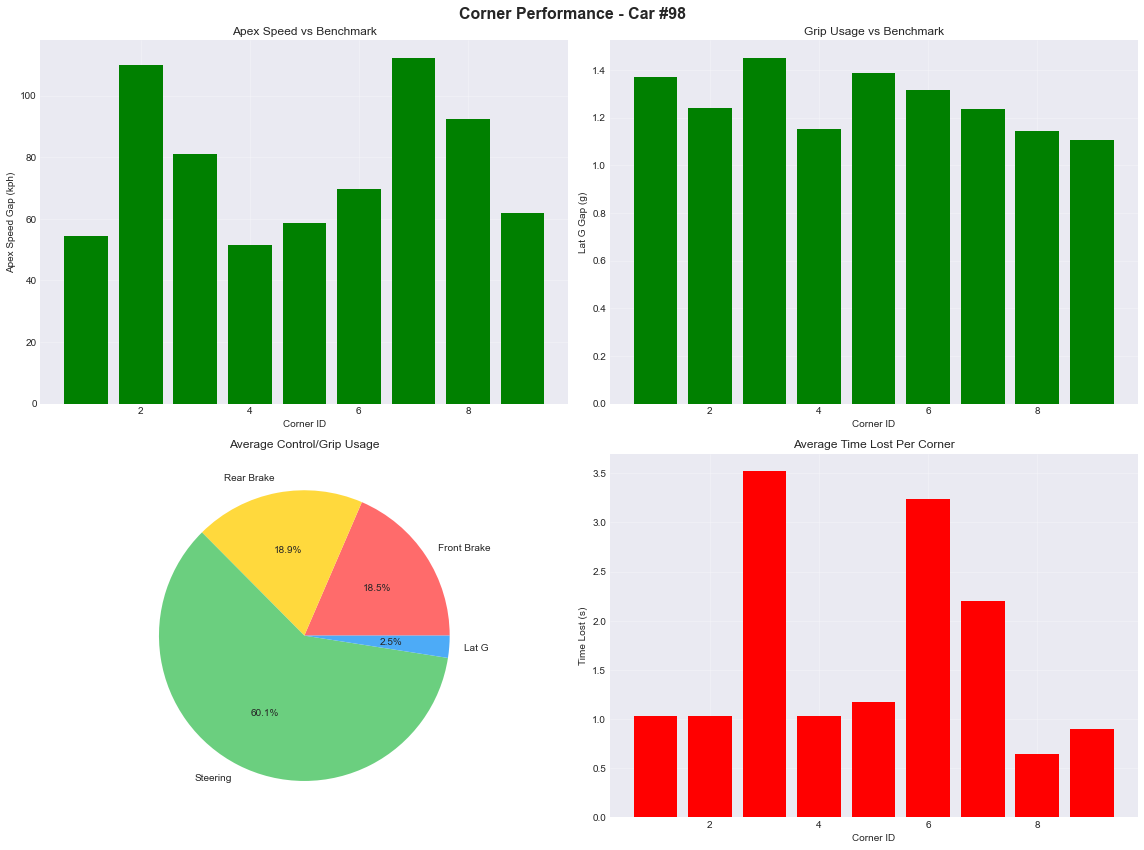

In [22]:
# CORNER BENCHMARKING ANALYSIS
df_metrics = extract_corner_performance(all_telemetry)
df_gaps = benchmark_against_fastest(df_metrics)

# Select a car number
YOUR_CAR = 98 

# Step 4: Generate report
report = generate_driver_report(df_gaps, YOUR_CAR)
print(report)

# Step 5: Visualize
visualize_corner_comparison(df_gaps, YOUR_CAR)

In [ ]:
# Check a corner
problem_corner = 3  # Pick one that shows NaN

print(f"Checking Corner {problem_corner}:")

# ----------------------------------------------------------------------
# 1) Average speed per lap_progress_bin for the selected corner
# ----------------------------------------------------------------------
print("\n📊 Average Speed per lap_progress_bin:")
corner_bins_summary = (
    all_telemetry[all_telemetry['corner_id'] == problem_corner]
    .groupby('lap_progress_bin')
    .agg(avg_speed=('speed', 'mean'))
    .reset_index()
)
display(corner_bins_summary)


# ----------------------------------------------------------------------
# 2) Show cars present in this corner
# ----------------------------------------------------------------------
print(f"\nVehicles with data in Corner {problem_corner}:")
vehicles_in_corner = (
    all_telemetry[all_telemetry['corner_id'] == problem_corner]['vehicle_number']
    .unique()
)
print(f"Total vehicles: {len(vehicles_in_corner)}")
print(f"Vehicles: {sorted(vehicles_in_corner)}")


# ----------------------------------------------------------------------
# 3) For each car, show avg speed, avg abs_lat_g, avg pbrake_f, avg pbrake_r
# ----------------------------------------------------------------------
# Remove cars that have 0 average speed in this corner
valid_corner_data = (
    all_telemetry[all_telemetry['corner_id'] == problem_corner]
    .groupby('vehicle_number')
    .filter(lambda g: g['speed'].mean() > 0)
)

print("\nCar-by-Car Summary (avg values):")
car_corner_stats = (
    valid_corner_data
    .groupby('vehicle_number')
    .agg(
        avg_speed=('speed', 'mean'),
        avg_lat_g=('abs_lat_g', 'mean'),
        avg_pbrake_f=('pbrake_f', 'mean'),
        avg_pbrake_r=('pbrake_r', 'mean'),
        data_points=('speed', 'count')
    )
    .reset_index()
)

display(car_corner_stats.sort_values('vehicle_number'))
# ----------------------------------------------------------------------
# 4) Sample data for a specific car (kept as your original test block)
# ----------------------------------------------------------------------
test_car = 8
print(f"\nSample data for Car {test_car} in Corner {problem_corner}:")
car_data_sample = all_telemetry[
    (all_telemetry['vehicle_number'] == test_car) &
    (all_telemetry['corner_id'] == problem_corner)
]
print(f"Data points: {len(car_data_sample)}")
if len(car_data_sample) > 0:
    display(
        car_data_sample[
            ['lap', 'lap_progress_bin', 'lap_progress',  'speed', 'abs_lat_g']
        ].head()
    )

Checking Corner 3:

📊 Average Speed per lap_progress_bin:


,lap_progress_bin,avg_speed
0,38,105.326734
1,39,99.015112
2,40,95.683137
3,41,94.269338
4,42,93.686851
5,43,93.882169
6,44,95.249763
7,45,97.332837
8,46,99.457443
9,47,99.569085



Vehicles with data in Corner 3:
Total vehicles: 30
Vehicles: [2, 3, 5, 7, 8, 11, 13, 14, 15, 16, 18, 21, 31, 41, 46, 47, 51, 55, 57, 71, 72, 73, 78, 80, 86, 88, 89, 93, 98, 113]

🚗 Car-by-Car Summary (avg values):


,vehicle_number,avg_speed,avg_lat_g,avg_pbrake_f,avg_pbrake_r,data_points
0,3,101.643582,0.254278,7.177637,7.261159,17485
1,5,90.310985,0.701042,2.144301,2.093764,8356
2,7,117.741909,0.947329,2.156192,2.251763,3193
3,8,91.434708,0.642976,1.525593,1.555241,8456
4,11,69.399846,0.581518,1.365270,1.390821,6649
5,13,91.743358,0.733364,1.742718,1.799247,8637
6,14,90.309641,0.743216,1.520331,1.592501,8775
7,15,111.188915,0.654308,3.313366,3.398544,3330
8,16,91.021084,0.732886,1.527501,1.597314,8750
9,18,105.591138,0.750288,2.058028,2.101341,7235



Sample data for Car 8 in Corner 3:
Data points: 8456


telemetry_name,lap,lap_progress_bin,lap_progress,speed,abs_lat_g
274649,2,38,19.019915,94.354,0.569
274650,2,38,19.042291,94.270,0.553
274651,2,38,19.064668,94.172,0.598
274652,2,38,19.087044,94.074,0.571
274653,2,38,19.109420,93.976,0.580
